In [743]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as stats
import numpy as np
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.interpolate
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import math
from astropy import units as u
from astropy.constants import k_B as kb
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [744]:
myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

In [745]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

In [806]:
T = 30
uam= 1.6605390666e-27
m=40

k_B = kb.value
k_B = 1

In [765]:
def fe(e, T):
    beta = 1/(T*k_B)
    A=np.sqrt(beta/np.pi)
    return A/np.sqrt(e)*np.exp(-beta*e)

def exp_val(e, T):
	return e*fe(e,T)

def Gaussian(x, mu, s):
    C = 1/(np.sqrt(2*np.pi)*s)
    return C*np.exp(-(x-mu)*(x-mu)/(2*s*s))

def moment_2(e, T):
	return e*e*fe(e,T)

Task-1

a. We want to demonstrate that $f(E_{\omega})$ is a PDF. To do so we must find the normalization constant $A$ for any temperature, and show that $f$ is positive. The second part is easy and will be demonstrate in the report. We can proove that the normalization is $\sqrt{\frac{\beta}{\pi}}$ numerically by integrate the function $f$ over the energy space, for different temperature and check that the given result is close to $1$

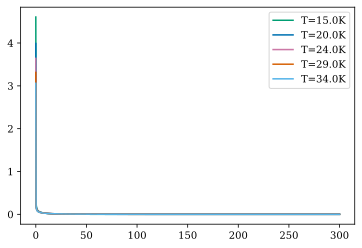

In [861]:
E = np.linspace(1e-3, 300, 1000)
t = np.linspace(5, 50, 30)
for i in range(5):
    plt.plot(E, fe(E, round(t[i]*3)), label=f'T={round(t[i]*3)}K')   
# plt.yscale('log')
plt.legend()

In [787]:
Norms = np.empty(len(t), dtype=object)

for i in range(len(Norms)):
    Norms[i] = integrate.quad(lambda eps: fe(eps, t[i]), 0, np.inf, epsrel = 1e-5)[0]

n_1 = 1/Norms

In [814]:
I = integrate.quad(fe, 0, np.inf, args =(T), epsrel = 1e-5)[0]
ExpVal = integrate.quad(exp_val, 0, np.inf, args =(T), epsrel = 1e-5)[0]
varPDF = integrate.quad(moment_2, 0, np.inf, args =(T), epsrel = 1e-5)[0]-ExpVal**2
mean_th = 1/2*k_B*T
corrFac = mean_th/ExpVal
delta   = (k_B*T)/(2*corrFac)
gamma   = (3/(5*corrFac))

print(  " The integral of f:\t" ,  I 
        ,"\n The exp.value: \t" , ExpVal
        , "\n The theoretical :\t", mean_th
        , "\n The variance  :\t", varPDF
        , "\n Mean Th after corr:\t", mean_th/corrFac)

 The integral of f:	 1.0000000000233806 
 The exp.value: 	 15.000000061237072 
 The theoretical :	 15.0 
 The variance  :	 449.9999981587827 
 Mean Th after corr:	 15.000000061237072


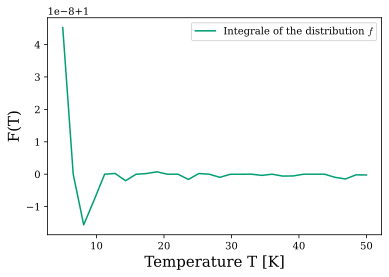

In [809]:
plt.plot(t, n_1, label='Integrale of the distribution $f$')
plt.xlabel("Temperature T [K]")
plt.ylabel("F(T)")
plt.legend()

b. Now we will build a MC process and verivy that the data set is correct.

In [989]:
def E_generator_plus(ninput, temp=30, nbins = 50):
    xinterval=(1e-3, 200)
    max=fe(1e-3, temp)
    fmax=max+0.02*max
    x_output=list(range(ninput))
    y_output=list(range(ninput))
    
    x_rejected=[]
    y_rejected=[]
    ii=0
    ir=0

    while ii<ninput:
        rx=np.random.uniform(xinterval[0],xinterval[1])
        ry=1/rx*np.random.uniform(0,1)

        if ry<fe(rx, temp):
            x_output[ii]=rx
            y_output[ii]=ry
            ii+=1
        else:
            x_rejected.append(rx)
            y_rejected.append(ry)
            ir+=1
    return x_output, y_output, x_rejected, y_rejected

def E_generator(ninput, temp=30, nbins = 50):
    xinterval=(1e-3, 200)
    x_output=list(range(ninput))
    ii=0
    

    while ii<ninput:
        rx=np.random.uniform(xinterval[0],xinterval[1])
        ry=1/rx**(1/2)*np.random.uniform(0,1)

        if ry<fe(rx, temp):
            x_output[ii]=rx
            ii+=1
    return x_output

def Weight(nbins, Datas, n_sample):

    weigth_accepted = 1/Datas**(1/2)*nbins/n_sample

    return weigth_accepted

In [997]:
DataSet = E_generator(1000, T)
print(len(DataSet))

1000


c. The theoritical expectation value is a bit lower because the Pdf should be taken from 0 but sinc the pdf is not define in this point building a montecarlo in this range is not possible

In [998]:
Expectation_th = 1/2*k_B*T
Expectation_sim = np.mean(DataSet)
print(Expectation_sim, Expectation_th)

30.39432860319003 15.0


Text(0, 0.5, '# Data points')

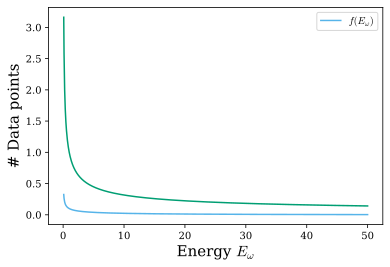

In [999]:
# plt.scatter(DataSet[0], DataSet[1], label='Accepted data', s=1, c=myColors[1])
# plt.scatter(DataSet[2], DataSet[3], label='Rejected data', s=1, c=myColors[2])
x = np.linspace(0.1, 50, 1000)
f =fe(x, T)
plt.plot(x, f, label='$f(E_{\omega})$', c=myColors[4])   
# plt.plot((0, 300), (fe(1e-3, T), fe(1e-3, T)), label = 'Uniform envelope')
plt.plot(x, 1/(x)**(1/2))
plt.legend(loc=1)
plt.xlabel('Energy $E_{\omega}$')
plt.ylabel('# Data points')
# plt.xlim(0, 0.1)
# plt.ylim(0,1)

In [1003]:
datas = np.array(DataSet)
datas = datas[datas<50]

W_A = Weight(50, datas, len(datas))


Text(0, 0.5, '# Data points')

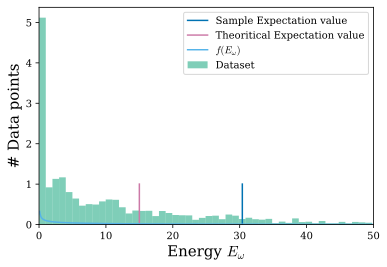

In [1004]:
bin_entries, bin_edges, _ = plt.hist(datas, 50, alpha=0.5, label='Dataset', weights=W_A)
plt.plot((Expectation_sim, Expectation_sim), (0, 1), label = 'Sample Expectation value')
plt.plot((Expectation_th, Expectation_th), (0, 1), label = 'Theoritical Expectation value')
plt.plot(x, f, label='$f(E_{\omega})$', c=myColors[4])   
plt.legend()
plt.xlim(0, 50)
# plt.ylim(0, 0.2)
plt.xlabel('Energy $E_{\omega}$')
plt.ylabel('# Data points')

In [845]:
DataSet_1 = E_generator(1000, T)
mean_1 =  np.mean(DataSet_1[0])
print(mean_1)

15.536143592177242


In [846]:
from scipy.stats import skew
from scipy.stats import kurtosis

s = skew(DataSet[0])
k = kurtosis(DataSet[0])
print(s, k)

2.6266958045768556 9.294658958963339


Task-2 
a. Law of large number

In [759]:
N=100000
DataSet_LLN = E_generator(N, T)[0]

In [847]:
DataSet_LLN = DataSet[0]

In [848]:
list_ntest = np.around(0.5*np.logspace(1, int(np.log10(N)), 500))
list_Average = np.empty(len(list_ntest), dtype=object)
l = len(list_ntest)
for i in range(l):
    moy = np.mean(DataSet_LLN[:int(list_ntest[i])])
    list_Average[i] = moy

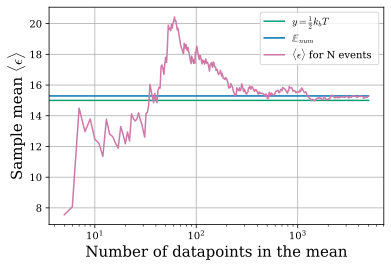

In [849]:
N=int(list_ntest[-1])
plt.plot([0,N],[1/2*T,1/2*T],  label = r"$y = \frac{1}{2}k_bT$")
plt.plot([0,N],[Expectation_sim,Expectation_sim], label = r"$\mathbb{E}_{num}$")
plt.plot(list_ntest, list_Average, label = r"$\langle\epsilon\rangle $ for N events ")

plt.xlabel("Number of datapoints in the mean")
plt.ylabel(r"Sample mean $\langle\epsilon\rangle$")
plt.legend()
plt.grid()
plt.xscale('log')

b. We want to compute the variance of $x = \sqrt{2E_{\omega}/m\omega^2}$ 

In [762]:
def x(E, omega=1):
    return np.sqrt(2*E/(m*omega**2))

c. Central limit theorem

In [850]:
n_exp = 1000
n_sample = [100, 500]

means_E_CLT = np.empty(len(n_sample), dtype=object)
vars_E_CLT = np.empty(len(n_sample), dtype=object)


for i in range(len(n_sample)):
    mean_E = np.empty(n_exp, dtype=object)
    var_E = np.empty(n_exp, dtype=object)
    n=0
    while n<n_exp:
        E_dataset = E_generator(n_sample[i], T)[0]
        mean_E[n] = np.mean(E_dataset)
        var_E[n] = np.var(E_dataset)
        n+=1
    
    means_E_CLT[i] = mean_E
    vars_E_CLT[i] = var_E

KeyboardInterrupt: 

The variance of the mean is  2.0684375770195678e-23 9.250334058861421e-24


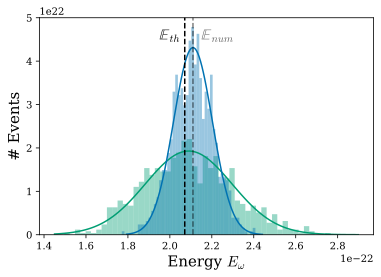

In [ ]:
Fig, bx = plt.subplots(figsize=(6,4))


Means_CLT = np.empty(len(n_sample), dtype=object)
sigma_CLT = np.empty(len(n_sample), dtype=object)

for i in range(len(n_sample)):
    Means_CLT[i] = np.mean(means_E_CLT[i])
    sigma_CLT[i] = np.sqrt(varPDF/(2*n_sample[i]))
    efit = np.linspace(ExpVal-3*sigma_CLT[i], ExpVal+4*sigma_CLT[i], 100)
    bx.plot(efit, Gaussian(efit, Means_CLT[i], sigma_CLT[i]))

bx.hist(means_E_CLT[0], alpha = 0.4, density = True, bins=50, color = myColors[0])
bx.hist(means_E_CLT[1], alpha = 0.4, density = True, bins=50, color = myColors[1])
bx.plot([mean_th, mean_th], [0, 6e22], 'k--')
bx.plot([np.mean(means_E_CLT[1]), np.mean(means_E_CLT[1])], [0, 6e22], 'k--', alpha=0.5)
bx.text(1.95e-22,4.5e22, '$\mathbb{E}_{th}$')
bx.text(2.15e-22,4.5e22, '$\mathbb{E}_{num}$', alpha=0.6)
bx.set_ylim(0, 5e22)
bx.set_xlabel('Energy $E_{\omega}$')
bx.set_ylabel('# Events')

print('The variance of the mean is ', sigma_CLT[0], sigma_CLT[1])

Task - 3
a. 

Text(0, 0.5, '# Events')

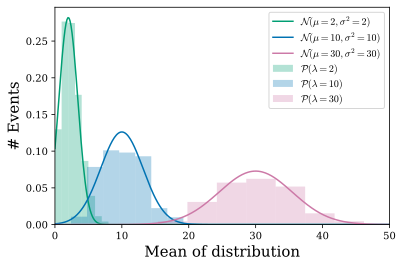

In [ ]:
xPoisson = np.linspace(0,60, 400)
plt.hist(np.random.poisson(2,10000) ,alpha = 0.3, color = myColors[0] , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=2)$")
plt.hist(np.random.poisson(10,10000) ,alpha = 0.3, color = myColors[1] , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=10)$")
plt.hist(np.random.poisson(30,10000),alpha = 0.3, color = myColors[2] , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=30)$")
plt.plot(xPoisson,Gaussian(xPoisson, 2, np.sqrt(2)), label = "$\mathcal{N}(\mu =2, \sigma^2 = 2)$")
plt.plot(xPoisson,Gaussian(xPoisson, 10, np.sqrt(10)), label = "$\mathcal{N}(\mu=10, \sigma^2 = 10)$")
plt.plot(xPoisson,Gaussian(xPoisson, 30, np.sqrt(30)), label = "$\mathcal{N}(\mu=30, \sigma^2 = 30) $")

plt.legend( )
plt.xlim(0,50)
plt.xlabel("Mean of distribution")
plt.ylabel("# Events")

b. First we can create a function that return the expted value for each bins, which will be used in to calculate the $\chi^2$ distribution: $\chi^2=\frac{(\#entries-expactation~value)^2}{expactation~value}$, for each bins.

In [ ]:
def bins_expectation(bin_edges,T):
    E = np.empty(len(bin_edges)-1, dtype=object)
    for i in range(len(bin_edges)-1):
        E[i] = integrate.quad(fe, bin_edges[i], bin_edges[i+1], args = (T))[0]
    return E

def chi_squared(bins_entries ,bin_edges, n_sample, T):
    
    f_scaled = n_sample*bins_expectation(bin_edges, T)
    c_squared = 0
    for i in range(len(bin_entries)):
        c_squared += (bin_entries[i]-f_scaled[i])**2/(f_scaled[i])
    return c_squared

In [ ]:
n_exp=1000
n_sample=1000

chis = np.empty(n_exp, dtype=object)
n_bins=14

for ii in range(n_exp):
    DataSet = E_generator(n_sample, T)[0]
    bin_entries, bin_edges = np.histogram(DataSet, bins=n_bins, density=False)
    chis[ii] = chi_squared(bin_entries, bin_edges, n_sample, T)

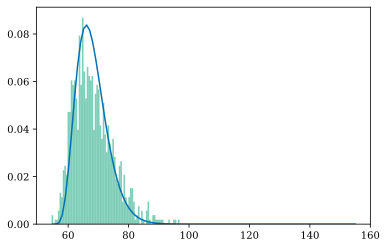

In [ ]:
x_fit = np.linspace(0, 100, 100)
Chi2 = stats.chi2.pdf(x_fit, df = n_bins-1, scale = 1)

plt.hist(chis, density=True, bins=80, alpha=0.5, label = '$\chi^2$ sample')
plt.plot(x_fit+55, Chi2, label='$\chi^2$ distribution')


In [ ]:
norm_G, _ = integrate.quad(lambda x: 1/np.sqrt(x), 0,  1e-21, epsrel = 1e-32)

def g(e):
    return 1/np.sqrt(e)/norm_G

def f_over_g(e, T):
    beta=1/(k_B*T)
    A = np.sqrt(beta/np.pi)
    return A*np.exp(-beta*e)/norm_G

def inverse_G(r):
    return np.power(r, 2)/norm_G

def Mixture_generator(n_input, T):

    max = f_over_g(0, T)
    fmax = max+0.02*max
    x_output=np.empty(n_input, dtype=object)
    ii=0
    while ii<n_input:
        r=np.random.uniform(0, 1)
        rx = inverse_G(r)
        ry = np.random.uniform(0, fmax)

        if ry<fe(rx, T)/g(rx):
            x_output[ii]=rx
            ii+=1
            print(ii)

    return x_output


In [ ]:
DataSet = Mixture_generator(1000, T)
plt.hist(DataSet, density=True)

KeyboardInterrupt: 

<ipython-input-479-2ab981bcf178>:4: RuntimeWarning: divide by zero encountered in true_divide
  return A/np.sqrt(e)*np.exp(-beta*e)


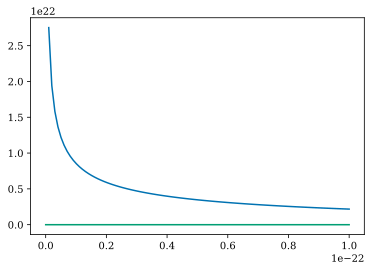

In [ ]:
x=np.linspace(0, 1e-22, 100)
plt.plot(x, f_over_g(x, T)/norm_G)
plt.plot(x, fe(x, T))

In [ ]:
import numpy as np
import random

def f(e, beta):
    return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)

def proposal_distribution(e_min, e_max):
    return random.uniform(e_min, e_max)

# Set the value of beta
beta = 1/(k_B*T)

# Set the limits of the proposal distribution
e_min = 0
e_max = 1e-21

# Set the number of samples to generate
n_samples = 10000

# Initialize an empty list to store the samples
samples = []
i=0
# Generate the samples
while i<n_samples:
    e = proposal_distribution(e_min, e_max)
    importance_weight = f(e, beta) / proposal_distribution(e_min, e_max)
    if random.uniform(0, 1) < importance_weight:
        samples.append(e)
        i+=1

# Compute the mean and variance of the samples
mean = np.mean(samples)
variance = np.var(samples)

print("Mean:", mean)
print("Variance:", variance)

Mean: 5.037765663990555e-22
Variance: 8.366182645550646e-44


<ipython-input-715-6c172141aa07>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)


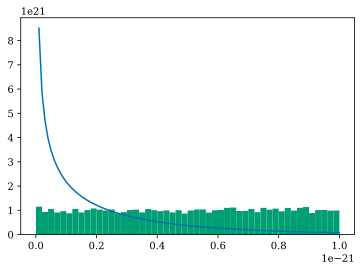

In [ ]:
plt.hist(samples, density=True, bins=50)
x = np.linspace(e_min, 1e-21, 100)
plt.plot(x, f(x, beta))

<ipython-input-742-a21abeec3b82>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)


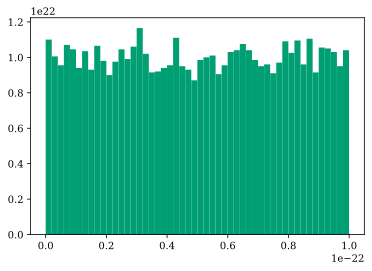

In [ ]:
import numpy as np
import random

def f(e, beta):
    return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)

def proposal_distribution(e_min, e_max):
    return random.uniform(e_min, e_max)

# Set the value of beta
k_B = 1.38e-23 # J/K
T = 30 # K
beta = 2

# Set the limits of the proposal distribution
e_min = 0
e_max = 1e-22

# Set the number of samples to generate
n_samples = 10000

# Initialize an empty list to store the samples
samples = []

i=0
# Generate the samples
while i<n_samples:
    e = proposal_distribution(e_min, e_max)
    importance_weight = f(e, beta) / proposal_distribution(e_min, e_max)
    if random.uniform(0, 1) < importance_weight:
        samples.append(e)
        i+=1

plt.hist(samples, density=True, bins=50)
x = np.linspace(e_min, e_max, 100)
plt.plot(x, f(x, beta))


<ipython-input-735-2552ef618477>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)


10000

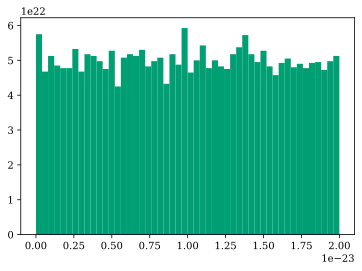

In [ ]:
plt.hist(samples, density=True, bins=50)
x = np.linspace(e_min, e_max, 100)
plt.plot(x, f(x, beta))
len(samples)

<ipython-input-679-3040bd5a202a>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)


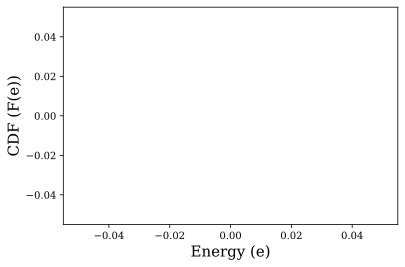